# Building Multi-Tool Agent Systems with LangChain, LangGraph and AstraDB

## Setup

In [143]:
!pip install -q astrapy langchain-groq langchain-community langchain-core langgraph \
    langchain-text-splitters langchain python-dotenv wikipedia tiktoken \
    langchain-huggingface sentence-transformers

In [147]:
from typing import List, TypedDict, Annotated
from dotenv import load_dotenv
from google.colab import userdata
from IPython.display import Image, display, HTML, Markdown
from astrapy import DataAPIClient
from collections import defaultdict

In [149]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
from langchain_classic.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

In [150]:
ASTRA_DB_APPLICATION_TOKEN = userdata.get("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID = userdata.get("ASTRA_DB_ID")
ASTRA_DB_API_ENDPOINT = f"https://{ASTRA_DB_ID}-us-east1.apps.astra.datastax.com"
groq_api_key = userdata.get('GROQ_API_KEY')

# AstraDB Connection

In [152]:
# If and database and collection is created on DataStax AstraDB, use .get(), otherwise use .create_database() and .create_collection()
client = DataAPIClient(ASTRA_DB_APPLICATION_TOKEN)
database = client.get_database(ASTRA_DB_API_ENDPOINT)
collection = database.get_collection("langgraph_react_demo")
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

print("Database configured")
print("Embeddings model loaded")

Database configured
Embeddings model loaded


## Populating Vector DB

In [153]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(f"Loaded {len(docs_list)} documents")

Loaded 3 documents


In [154]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
print(f"Created {len(doc_splits)} chunks")

Created 88 chunks


In [155]:
documents_to_insert = [
    {
        "_id": str(i),
        "content": doc.page_content,
        "metadata": doc.metadata,
        "$vector": embeddings.embed_query(doc.page_content),
    }
    for i, doc in enumerate(doc_splits)
]

collection.insert_many(documents_to_insert)
print(f"Inserted {len(doc_splits)} documents into AstraDB")

Inserted 88 documents into AstraDB


# Tool Creation

In [156]:
from pydantic import BaseModel, Field
from langchain_core.tools import Tool

def vector_store_search(query: str) -> str:

    query_embedding = embeddings.embed_query(query)
    results = collection.find(
        sort={"$vector": query_embedding},
        limit=3,
        include_similarity=True
    )

    documents = []
    for result in results:
        documents.append(result['content'])

    return "\n\n---\n\n".join(documents)

class VectorStoreSearchInput(BaseModel):
    query: str = Field(description="The query string to search for in the vector store.")

vector_tool = Tool(
    name="VectorStoreSearch",
    func=vector_store_search,
    description="Search the vector store for information about AI agents, prompt engineering, and adversarial attacks. Use this for technical AI topics.",
    args_schema=VectorStoreSearchInput
)

In [157]:
def wikipedia_search(query: str) -> str:

    api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
    try:
        result = api_wrapper.run(query)
        return result
    except Exception as e:
        return f"Wikipedia search failed: {str(e)}"

class WikiSearchInput(BaseModel):
    query: str = Field(description="The query string to search from Wikipedia")

wiki_tool = Tool(
    name="WikipediaSearch",
    func=wikipedia_search,
    description="Search Wikipedia for general knowledge questions about people, places, events, and other topics.",
    args_schema=WikiSearchInput
)

tools = [vector_tool, wiki_tool]

# LangChain Agent

In [158]:
llm = ChatGroq(api_key=groq_api_key, model="meta-llama/llama-4-maverick-17b-128e-instruct", temperature=0)

prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful AI assistant with access to tools.
    You have access to:
    - VectorStoreSearch: For questions about AI agents, prompt engineering, and adversarial attacks
    - WikipediaQueryRun: For general knowledge questions

    Think carefully about which tool to use for each question. You can use multiple tools if needed.
    Provide clear, concise answers based on the information you retrieve."""),

    MessagesPlaceholder(variable_name="chat_history", optional=True),
    ("human", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

agent = create_tool_calling_agent(llm, tools, prompt)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=5,
    return_intermediate_steps=True
)

print("LangChain agent created")

LangChain agent created


# LangGraph Agent

In [159]:
memory = MemorySaver()

graph_agent = create_react_agent(
    llm,
    tools,
    checkpointer=memory
)

print("LangGraph agent with checkpoint")

LangGraph agent with checkpoint


/tmp/ipython-input-181701143.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  graph_agent = create_react_agent(


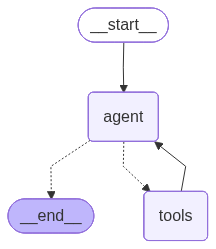

In [160]:
try:

    display(Image(graph_agent.get_graph().draw_mermaid_png()))

except Exception as e:

    print(f"Graph visualization error: {e}")

# LangChain Agent Execution

In [161]:
print("\n")
print("=" * 80)
print("LANGCHAIN AGENT EXECUTION")
print("=" * 80)
print("\nQUERY: What are the types of agent memory?\n")
print("=" * 80)

result = agent_executor.invoke({"input": "What are the various types of agent memory?"})

print("\n")
print("=" * 80)
print("EXECUTION TRACEBACK")
print("=" * 80)

for i, step in enumerate(result['intermediate_steps'], 1):
    action, observation = step
    print(f"\nStep {i}:")
    print(f"  Tool: {action.tool}")
    print(f"  Input: {action.tool_input}")
    print(f"  Output Preview: {observation[:150]}...")

print("\n")
print("=" * 80)
print("FINAL OUTPUT")
print("=" * 80)
print(f"\n{result['output']}\n")




LANGCHAIN AGENT EXECUTION

QUERY: What are the types of agent memory?



> Entering new AgentExecutor chain...

Invoking: `VectorStoreSearch` with `{'query': 'types of agent memory'}`


inquired about current trends in anticancer drug discovery;
selected a target;
requested a scaffold targeting these compounds;
Once the compound was identified, the model attempted its synthesis.

They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out of 11 requests (36%) were accepted to obtain a synthesis solution and the agent attempted to consult documentation to execute the procedure. 7 out of 11 were rejected and among these 7 rejected cases, 5 happened after a Web search while 2 were rejected based on prompt only.
Generative Agents Simulation#
Generative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a

# LangGraph Agent Execution

In [162]:
print("\n")
print("=" * 80)
print("LANGGRAPH AGENT EXECUTION")
print("=" * 80)
print("\nQUERY: Who is Shah Rukh Khan?\n")
print("=" * 80)
print("\n")

config = {"configurable": {"thread_id": "test-1"}}

messages_collected = []
for chunk in graph_agent.stream(
    {"messages": [HumanMessage(content="Who is Shah Rukh Khan?")]},
    config,
    stream_mode="values"
):
    messages_collected.append(chunk["messages"][-1])
    chunk["messages"][-1].pretty_print()

print("\n")
print("=" * 80)
print(f"GRAPH STATE: {len(messages_collected)} messages in conversation")
print("="*80)
print("\n")



LANGGRAPH AGENT EXECUTION

QUERY: Who is Shah Rukh Khan?



================================ Human Message =================================

Who is Shah Rukh Khan?
================================== Ai Message ==================================
Tool Calls:
  WikipediaSearch (tgwfcjttc)
 Call ID: tgwfcjttc
  Args:
    query: Shah Rukh Khan
================================= Tool Message =================================
Name: WikipediaSearch

Page: Shah Rukh Khan
Summary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born as Shahrukh Khan on 2 November 1965), popularly known by the initials SRK, is an Indian actor and film producer renowned for his work in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 100 films and earned numerous accolades, including a National Film Award and 15 Filmfare Awards. He has been awarded the Padma Shri by the Government of India, as well
================================== Ai Message =====

#Multi Turn Conversation with LangGraph

In [163]:
print("\n")
print("=" * 80)
print("MULTI-TURN CONVERSATION")
print("=" * 80)
print("\n")

config = {"configurable": {"thread_id": "conversation-1"}}

questions = [
    "What is an AI agent?",
    "What tools can it use?",
    "How does memory work in agents?"
]

for i, question in enumerate(questions, 1):
    print(f"Turn {i}")
    print("-"*80)
    print(f"USER: {question}\n")

    step_count = 0
    for chunk in graph_agent.stream(
        {"messages": [HumanMessage(content=question)]},
        config,
        stream_mode="values"
    ):
        step_count += 1
        chunk["messages"][-1].pretty_print()

    print(f"\nGraph executed {step_count} steps")
    print("=" * 80)
    print("\n")



MULTI-TURN CONVERSATION


Turn 1
--------------------------------------------------------------------------------
USER: What is an AI agent?

================================ Human Message =================================

What is an AI agent?
================================== Ai Message ==================================
Tool Calls:
  VectorStoreSearch (tzttbd49r)
 Call ID: tzttbd49r
  Args:
    query: AI agent
================================= Tool Message =================================
Name: VectorStoreSearch

LLM Powered Autonomous Agents | Lil'Log







































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Two: Memory

Types of Memory

Maximum Inner Product Search (MIPS

In [164]:
#Unified Calling

def ask_agent(question: str, use_langgraph=True, thread_id="default"):

    #thread_id: Thread ID for conversation memory

    print("\n")
    print("=" * 80)
    print(f"QUERY: {question}")
    print("=" * 80)
    print( "\n")

    if use_langgraph:
        print("[Using LangGraph Agent with Memory]\n")
        config = {"configurable": {"thread_id": thread_id}}

        step_count = 0
        tool_calls = []

        for chunk in graph_agent.stream(
            {"messages": [HumanMessage(content=question)]},
            config,
            stream_mode="values"
        ):
            step_count += 1
            msg = chunk["messages"][-1]

            # Track tool calls
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                for tc in msg.tool_calls:
                    tool_calls.append(tc['name'])

            msg.pretty_print()

        print(f"\n{'─'*80}")
        print(f"Graph Steps: {step_count} | Tools Used: {', '.join(set(tool_calls)) if tool_calls else 'None'}")
        print("="*80 + "\n")

    else:

        print("[Using LangChain Agent]\n")
        result = agent_executor.invoke({"input": question})

        print("\nExecution Trace:")
        print("="*80)
        for i, step in enumerate(result['intermediate_steps'], 1):
            action, observation = step
            print(f"Step {i}: {action.tool}")

        print("\n")
        print("=" * 80)
        print("ANSWER")
        print("="*80)
        print(result['output'])
        print("=" * 80)
        print("\n")

In [165]:
ask_agent("Explain the different types of prompt engineering techniques", use_langgraph=True)
ask_agent("Who is Albert Einstein?", use_langgraph=True)
ask_agent("Compare adversarial attacks with prompt engineering methods", use_langgraph=False)



QUERY: Explain the different types of prompt engineering techniques


[Using LangGraph Agent with Memory]

================================ Human Message =================================

Explain the different types of prompt engineering techniques
================================== Ai Message ==================================
Tool Calls:
  VectorStoreSearch (chgjpp1et)
 Call ID: chgjpp1et
  Args:
    query: prompt engineering techniques
================================= Tool Message =================================
Name: VectorStoreSearch

Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.
This post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests,

In [166]:
def visualize_conversation_state(thread_id: str):

    config = {"configurable": {"thread_id": thread_id}}
    state = graph_agent.get_state(config)

    print("\n")
    print("=" * 80)
    print(f"CONVERSATION STATE: Thread '{thread_id}'")
    print("="*80)
    print("\n")

    if state and hasattr(state, 'values') and 'messages' in state.values:
        messages = state.values['messages']
        print(f"Total messages in thread: {len(messages)}\n")

        for i, msg in enumerate(messages, 1):
            role = type(msg).__name__.replace('Message', '')
            content_preview = str(msg.content)[:100] + "..." if len(str(msg.content)) > 100 else str(msg.content)
            print(f"{i}. [{role}] {content_preview}")
    else:
        print("No conversation history found")

    print("\n")
    print("=" * 80)
    print("\n")

visualize_conversation_state("state-test")




CONVERSATION STATE: Thread 'state-test'


No conversation history found




